### **Import Dependencies**

In [65]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

### **Create a dataset**

Define some parameters for the loading dataset:

In [66]:
BATCH_SIZE = 32
IMG_HEIGHT = 256
IMG_WIDTH = 256
EPOCHS = 50
CHANNELS = 3

Import data into tensorflow dataset object

In [67]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'PlantVillage',
    shuffle= True,
    image_size= (IMG_HEIGHT, IMG_WIDTH),
    batch_size= BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [68]:
dataset.class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [69]:
# Assign the divided names from dataset
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [70]:
len(dataset)

68

Here some first images from the dataset

In [71]:
for image_batch, label_image in dataset.take(1):
    print(image_batch.shape)
    print(label_image)

(32, 256, 256, 3)
tf.Tensor([2 1 0 0 1 1 1 0 1 1 0 1 0 1 1 1 0 1 0 0 1 0 0 1 1 0 0 0 0 1 0 0], shape=(32,), dtype=int32)


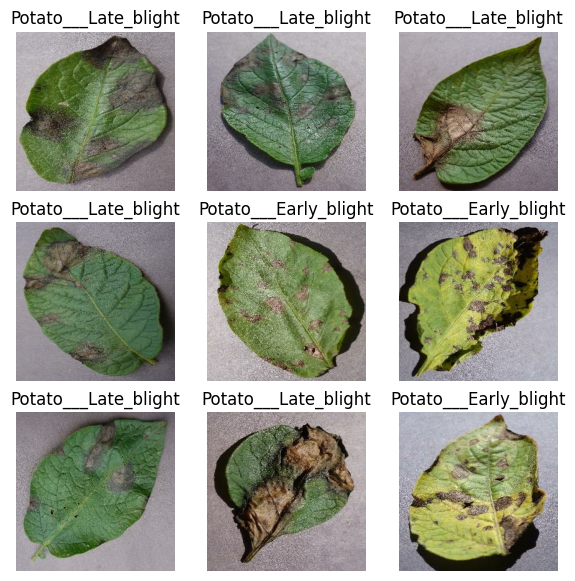

In [72]:
plt.figure(figsize= (7, 7))
for image_batch, label_image in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_image[i]])
        plt.axis("off")

### **Split the dataset**

In [73]:
# 80% => training
# 10% => validation, 10% => testing

In [74]:
len(dataset)

68

In [75]:
# Function to split the dataset into traing, validation, and testing
def split_the_dataset(dataset, train_split= 0.8, valid_split= 0.1, test_split= 0.1, shuffle= True, shuffle_size= 1000):
    ds_size = len(dataset)
    
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed= 42)
        
    train_size = int(ds_size*train_split) # 54
    valid_size = int(ds_size*valid_split) # 7
    
    train_data = dataset.take(train_size)
    valid_data = dataset.skip(train_size).take(valid_size)
    test_data = dataset.skip(train_size).skip(valid_size)
    
    return train_data, valid_data, test_data

In [76]:
train_data, valid_data, test_data = split_the_dataset(dataset)

In [77]:
print("The shape of training set:", len(train_data))
print("The shape of validataion set:", len(valid_data))
print("The shape of test set:", len(test_data))

The shape of training set: 54
The shape of validataion set: 6
The shape of test set: 8


Cache, Shuffle, and Prefetch the dataset 

In [78]:
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
valid_data = valid_data.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)

### **Image Processing**

In [79]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMG_HEIGHT, IMG_WIDTH),
    layers.Rescaling(1./ 255)
])

In [80]:
data_agumentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

### **Model Building**

In [81]:
import numpy as np

# Initialize parameters
input_shape = (BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, CHANNELS)
n_classes = len(np.unique(class_names))

In [82]:
class MyModel(tf.keras.Model):
    def __init__(self, n_classes):
        super(MyModel, self).__init__()
        
        # Stick the image processing step before initializing layers
        self.resize_and_rescale = resize_and_rescale
        self.data_agumentation = data_agumentation
        
        # Building layers
        self.conv1 = layers.Conv2D(32, kernel_size= (3, 3), activation= 'relu')
        self.pool1 = layers.MaxPooling2D((2, 2))
        self.conv2 = layers.Conv2D(64, kernel_size= (3, 3), activation= 'relu')
        self.pool2 = layers.MaxPooling2D((2, 2))
        self.conv3 = layers.Conv2D(64, kernel_size= (3, 3), activation= 'relu')
        self.pool3 = layers.MaxPooling2D((2, 2))
        self.conv4 = layers.Conv2D(64, kernel_size= (3, 3), activation= 'relu')
        self.pool4 = layers.MaxPooling2D((2, 2))
        self.conv5 = layers.Conv2D(64, kernel_size= (3, 3), activation= 'relu')
        self.pool5 = layers.MaxPooling2D((2, 2))
        self.conv6 = layers.Conv2D(64, kernel_size= (3, 3), activation= 'relu')
        self.pool6 = layers.MaxPooling2D((2, 2))
        
        # Flatten 
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(64, activation= 'relu')
        self.dense2 = layers.Dense(n_classes, activation= 'softmax')
        
    
    def call(self, inputs, training= False):
        x = inputs
        
        # Applying image processing step 
        x = self.resize_and_rescale(inputs)
        
        # Apply data agumentation in training 
        if training:
            x = self.data_agumentation(x)
            
        # Remaining layers
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.pool4(x)
        x = self.conv5(x)
        x = self.pool5(x)
        x = self.conv6(x)
        x = self.pool6(x)
        
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

In [83]:
# Building model
model = MyModel(n_classes= n_classes)
model.build(input_shape= input_shape)

d:\Python 3.10.8\lib\site-packages\keras\src\layers\layer.py:395: UserWarning: `build()` was called on layer 'my_model_11', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [87]:
dummy_input = tf.random.normal((BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, CHANNELS))
model(dummy_input)

<tf.Tensor: shape=(32, 3), dtype=float32, numpy=
array([[0.3334248 , 0.33307147, 0.3335037 ],
       [0.33341965, 0.33306974, 0.33351055],
       [0.3334146 , 0.33307862, 0.3335068 ],
       [0.33344668, 0.33305869, 0.33349457],
       [0.3334183 , 0.33307013, 0.3335116 ],
       [0.33341956, 0.3330611 , 0.3335193 ],
       [0.33341423, 0.33309305, 0.3334927 ],
       [0.33342314, 0.33307162, 0.33350524],
       [0.33342847, 0.3330546 , 0.33351696],
       [0.33341834, 0.33309484, 0.33348683],
       [0.33342794, 0.33307195, 0.3335001 ],
       [0.33342946, 0.33307022, 0.3335003 ],
       [0.33342847, 0.33304483, 0.3335268 ],
       [0.33342278, 0.33308446, 0.3334927 ],
       [0.3334268 , 0.33308002, 0.33349314],
       [0.33341235, 0.3330743 , 0.33351332],
       [0.333418  , 0.33308205, 0.33349988],
       [0.33342433, 0.33306685, 0.33350885],
       [0.33343554, 0.33307347, 0.33349097],
       [0.3334432 , 0.3330632 , 0.33349365],
       [0.33342382, 0.33306473, 0.3335115 ],
      

In [88]:
model.summary()

Model: "my_model_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_60 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_61 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_62 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_63 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_64 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_65 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

#### Compile the model

In [89]:
model.compile(
    optimizer= 'adam',
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits= False),
    metrics= ['accuracy']
)

In [90]:
history = model.fit(
    train_data,
    batch_size= BATCH_SIZE,
    validation_data= valid_data,
    verbose= 1, # hiển thị progress bar để theo dõi
    epochs= 50
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.4615 - loss: 0.9205 - val_accuracy: 0.5938 - val_loss: 0.8091
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.6796 - loss: 0.6603 - val_accuracy: 0.6875 - val_loss: 0.5839
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8056 - loss: 0.4352 - val_accuracy: 0.8438 - val_loss: 0.3968
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.8530 - loss: 0.3298 - val_accuracy: 0.8333 - val_loss: 0.4006
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 50s 921ms/step - accuracy: 0.8814 - loss: 0.2776 - val_accuracy: 0.8646 - val_loss: 0.3132
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 48s 879ms/step - accuracy: 0.8852 - loss: 0.2996 - val_accuracy: 0.8385 - val_loss: 0.4796
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 46s 859ms/step - accuracy: 0.9216 - loss: 0.2199 - val_accuracy: 0.9323 - val_loss: 0.1704
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 51s 948ms/step - accuracy: 0.9159 - loss: 0.2151 - val_accuracy: 0.8958

In [91]:
score = model.evaluate(test_data)
score

8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 394ms/step - accuracy: 0.9626 - loss: 0.0824


[0.06893462687730789, 0.97265625]

#### Predict on sample image

First image to predict:
Actual prediction: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
[9.9999976e-01 2.9517565e-07 1.9302633e-17]
Predicted label: Potato___Early_blight


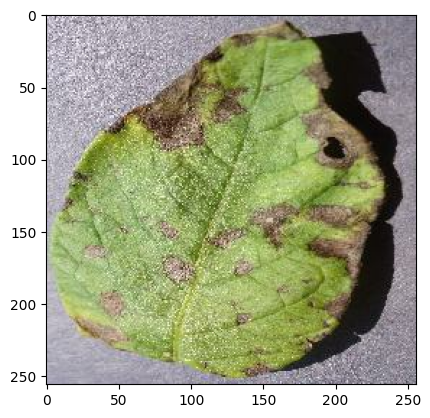

In [92]:
for image, label in test_data.take(1):
    
    first_img = image[0].numpy().astype("uint8")
    first_label = label[0]
    
    print("First image to predict:")
    plt.imshow(first_img)
    print("Actual prediction:", class_names[first_label])
    
    model_prediciton = model.predict(image)
    print(model_prediciton[0])
    print("Predicted label:", class_names[np.argmax(model_prediciton[0])])

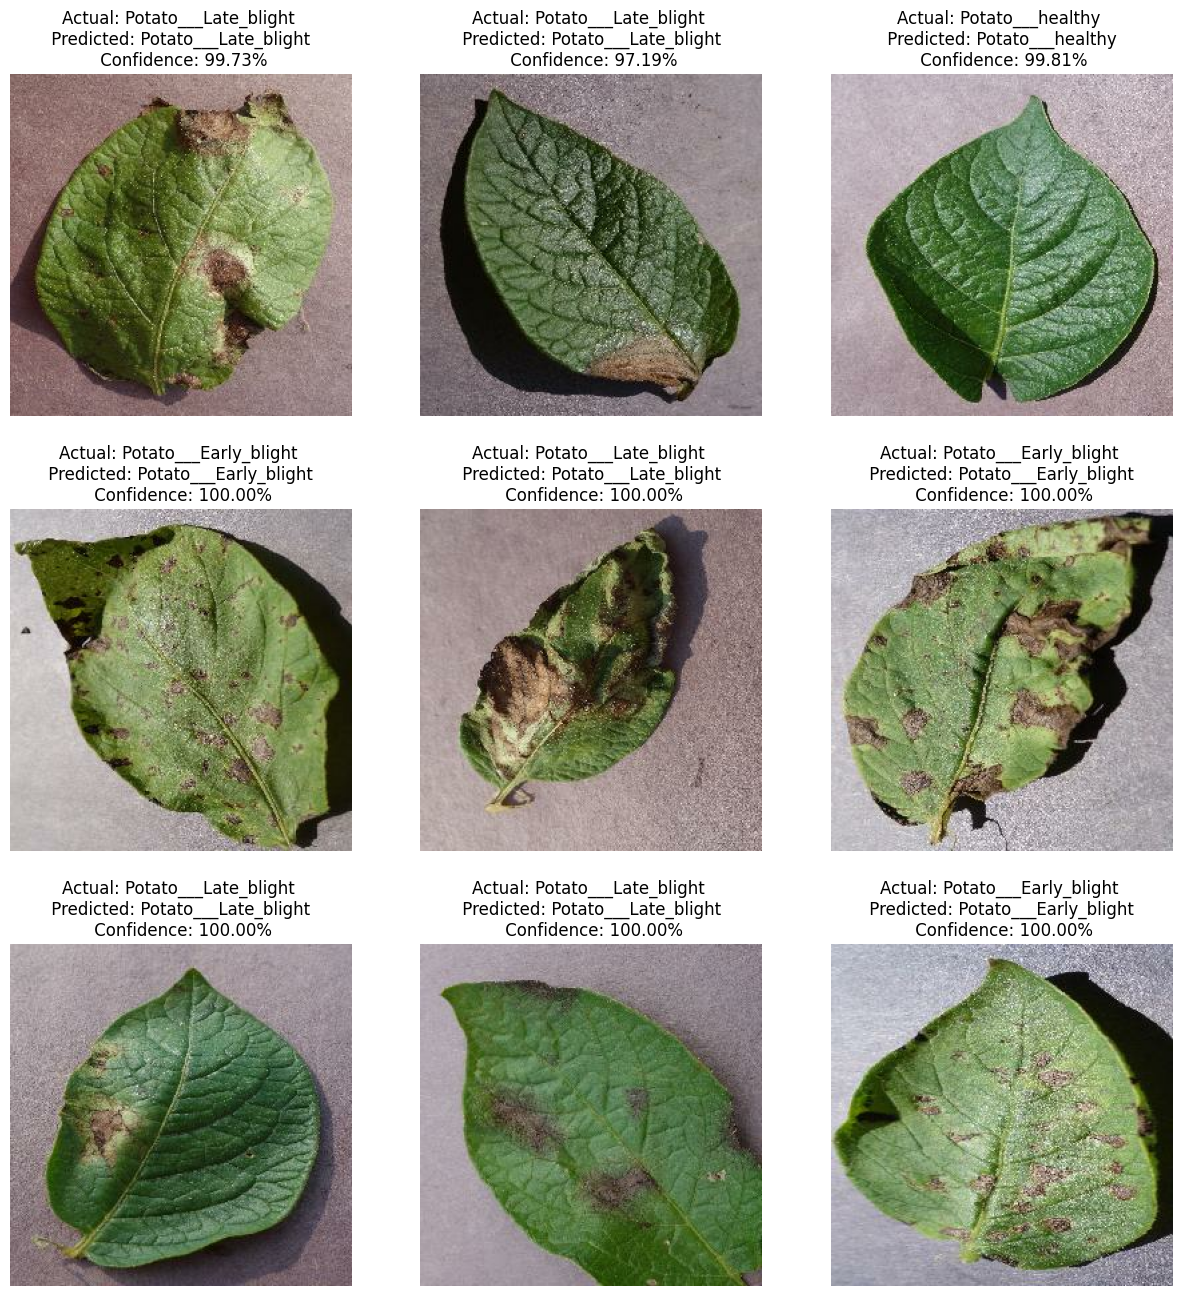

In [93]:
plt.figure(figsize= (15, 16))

for image_batch, label_batch in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        img = image_batch[i].numpy()
        plt.imshow(img.astype("uint8"))
        
        # Predict the image
        img_array = tf.expand_dims(img, 0) # Add batch dimension to shape (1, h, w, channels)
        prediction = model.predict(img_array, verbose= 0)
        predicted_label = class_names[np.argmax(prediction[0])]
        confidence = np.max(prediction[0]) * 100
                        
        plt.title(f"Actual: {class_names[label_batch[i]]} \n Predicted: {predicted_label} \n Confidence: {confidence:.2f}%")
        plt.axis("off")

### **Save the model**

In [109]:
import os
model_version = max([int(i) for i in os.listdir("../models") + [0]]) + 1
model.export(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/3\assets


INFO:tensorflow:Assets written to: ../models/3\assets


Saved artifact at '../models/3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2400703061808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2400703059696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2400703062688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2400703061280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2400703064272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2400703058816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2400703065856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2400703058464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2400703067440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2400703063920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2400703065504: TensorSpec(shape=(), dtype=tf.reso